In [1]:
import sys 
sys.path.append('..')

from copy import deepcopy
from pathlib import Path

import pandas as pd
import numpy as np

from IPython.display import display

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from preprocessing.grouping.clustering_pipelines import clust_kproto
from preprocessing.grouping.explainer import explainer_sklearn_dt

from preprocessing.activity_feature_extraction.activity_transformer import ActivityTransformer

# Activity level variability analysis (w/o case type grouping)

#### Discover activity clusters (k-prototypes)

In [2]:
INPUT_DF_NAME = './outputs/consulta_intercase_and_kproto'
OUTPUT_DF_NAME = './outputs/consulta_activity_no_case_group'

pd.set_option('display.float_format', lambda x: '%.2f' % x)

log_df = pd.read_pickle(INPUT_DF_NAME).drop(columns=["k_proto_cluster"])

transformer = ActivityTransformer(log_df)
log_df = transformer.transform()

In [3]:
df = deepcopy(log_df)

# Clean up: exclude cols, drop NAN
excluded = ['@@duration', 'end_timestamp', 'start_timestamp', 'Activity', 'Resource', 'Role', '@@startevent_concept:name',
       '@@startevent_org:resource', '@@startevent_Activity',
       '@@startevent_Resource', 'n_role', 'role', 'n_task']

df = df.drop(columns=["caseid"] + excluded, errors='ignore').dropna()
df = df[df.columns.drop(list(df.filter(regex='@@startevent_')))]

# Categorical pre-proc
cat_cols = ['user', 'timetable_id', 'st_weekday', 'end_weekday', 'st_month', 'end_month', "started_offtimetable", "ended_offtimetable"]

cat_cols = list(set(cat_cols + list(df.select_dtypes(['object']).columns)))
cat_cols = list(filter(lambda c : c != 'task', cat_cols))
display(cat_cols)

for c in cat_cols:
    df[c] = df[c].apply(str)

# Numerical pre-proc
num_cols = list(df.select_dtypes(['number']).columns)

by_activity = df.groupby('task')

display(df.head())

activities_srt_by_duration_std = by_activity\
                                            .agg({'processing_time': np.std, 'task': np.size})\
                                            .rename(columns={'task':'count', 'processing_time':'processing_time_std'})\
                                            .sort_values(by="processing_time_std", ascending=False)

display(activities_srt_by_duration_std)


['started_offtimetable',
 'ended_offtimetable',
 'end_month',
 'st_month',
 'end_weekday',
 'user',
 'timetable_id',
 'st_weekday']

,task,user,st_wip,st_tsk_wip,rp_st_oc,end_wip,rp_end_oc,daytime,st_daytime,st_weekday,...,timetable_id,processing_time,waiting_time,started_offtimetable,ended_offtimetable,ocurrences_in_trace,accumulated_activity_time,index_in_trace,res_st_oc,res_end_oc
0,Traer informacion estudiante - banner,7071,192,0,0.00,192,0.00,0,3595,6,...,QBP_RES_ROLE_1_TIMETABLE,0.00,0.00,False,True,1,0,0,0,0
1,Radicar Solicitud Homologacion,7071,192,0,0.00,192,0.00,0,3602,6,...,QBP_RES_ROLE_1_TIMETABLE,0.00,0.00,False,True,1,0,1,0,0
2,Validar solicitud,22475,192,1,0.03,192,0.00,0,4789,6,...,QBP_RES_ROLE_3_TIMETABLE,7.00,0.00,False,True,1,7,2,1,0
3,Revisar curso,22475,188,0,0.03,188,0.02,0,54460,0,...,QBP_RES_ROLE_3_TIMETABLE,0.00,0.00,False,True,1,0,3,0,0
4,Homologacion por grupo de cursos,22478,188,1,0.02,188,0.05,0,54460,0,...,QBP_RES_ROLE_2_TIMETABLE,472.00,0.00,True,False,1,472,4,1,1


,processing_time_std,count
task,,
Recepcion de documentos,11520.41,23
Avanzar recepcion documentos,10599.88,14
Homologacion por grupo de cursos,7852.24,479
Cancelar Solicitud,6767.73,425
Evaluacion curso,6653.66,237
Cancelar curso,5333.09,21
Revisar curso,3343.65,281
Validar solicitud,2783.09,562
Visto Bueno Cierre Proceso,2776.92,153


'Analized activity: Homologacion por grupo de cursos'

,processing_time,waiting_time
count,479.00,479.00
mean,7094.44,122.63
std,7852.24,658.98
min,0.00,0.00
25%,1007.50,0.00
50%,4189.00,0.00
75%,10494.00,0.00
max,44245.00,3720.00


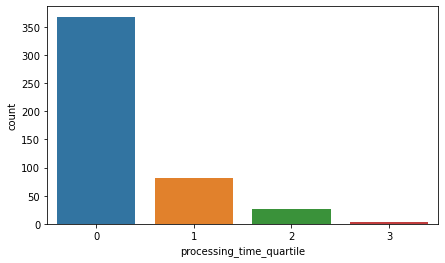

In [4]:
# TO-DO extend to all activities (or a subset of most relevant)

#activity_name = activities_srt_by_duration_std.head(1).index[0]
activity_name = "Homologacion por grupo de cursos"	

activity_df = by_activity.get_group(activity_name).drop(columns=["task"])

activity_df['processing_time_quartile'] = pd.cut(activity_df['processing_time'], bins=4, 
                                     labels=list(range(0,4)))

#cat_cols.append('processing_time_quartile')

categorical_indexes = [activity_df.columns.get_loc(f"{c}") for c in cat_cols]
num_cols = activity_df.columns[list(set(list(range(0, len(activity_df.columns))))-set(categorical_indexes))]

display(f"Analized activity: {activity_name}")
display(activity_df[['processing_time', 'waiting_time']].describe())

plt.subplots(figsize = (7, 4))
sns.countplot(x='processing_time_quartile', data = activity_df)
plt.show()    

Cost: 401.6916298291417


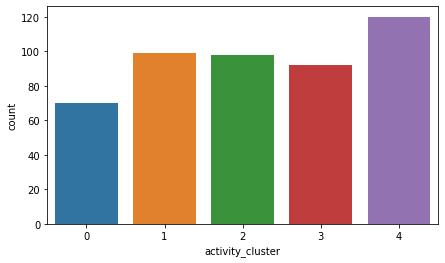

In [5]:
clusters, centers  = clust_kproto(activity_df, categorical_indexes, num_cols, K_MODES_ELBOW=5) # elbow value 0 to force best k re-computation

activity_df['activity_cluster'] = clusters
activity_df.to_pickle(OUTPUT_DF_NAME)

plt.subplots(figsize = (7, 4))
sns.countplot(x='activity_cluster', data = activity_df)
plt.show()

#### Explainability: Activity Clusters


Grouping by activity_cluster

7 Decision Rules found:

if (st_wip > 181.0) and (end_daytime > 42254.0) and (end_month_4 > 0.5) then class = 1 | Prob: 82.88%, based on 111 samples
if (st_wip <= 181.0) and (end_daytime > 20797.5) and (end_wip <= 119.0) then class = 4 | Prob: 88.57%, based on 105 samples
if (st_wip > 181.0) and (end_daytime > 42254.0) and (end_month_4 <= 0.5) then class = 3 | Prob: 79.59%, based on 98 samples
if (st_wip > 181.0) and (end_daytime <= 42254.0) and (end_wip > 196.0) then class = 2 | Prob: 97.7%, based on 87 samples
if (st_wip <= 181.0) and (end_daytime > 20797.5) and (end_wip > 119.0) then class = 0 | Prob: 64.71%, based on 51 samples
if (st_wip <= 181.0) and (end_daytime <= 20797.5) then class = 2 | Prob: 52.0%, based on 25 samples
if (st_wip > 181.0) and (end_daytime <= 42254.0) and (end_wip <= 196.0) then class = 0 | Prob: 50.0%, based on 2 samples


processing_time                                         \
                           count     mean     std  min     25%      50%   
activity_cluster                                                          
0                          70.00  3128.41 4250.41 0.00  112.50  1109.50   
1                          99.00  4561.27 4285.99 0.00 1129.00  3681.00   
2                          98.00 11551.65 9431.18 0.00 3582.25 10100.00   
3                          92.00  7971.54 6731.84 0.00 2635.25  7287.00   
4                         120.00  7185.33 9129.68 0.00  921.75  3097.50   

                                   waiting_time                                \
                      75%      max        count   mean     std  min  25%  50%   
activity_cluster                                                                
0                 4234.25 16016.00        70.00   0.00    0.00 0.00 0.00 0.00   
1                 6467.50 17772.00        99.00   0.00    0.00 0.00 0.00 0.00   
2                17343.25 39658.00        98.00 523.47 1287.08 0.00 0.00 0.00   
3                11289.75 26169.00        92.00   0.00    0.00 0.00 0.00 0.00   
4                10063.25 44245.00       120.00  62.00  474.35 0.00 0.00 0.00   

                               
                  75%     max  
activity_cluster               
0                0.00    0.00  
1                0.00    0.00  
2                0.00 3660.00  
3                0.00    0.00  
4                0.00 3720.00

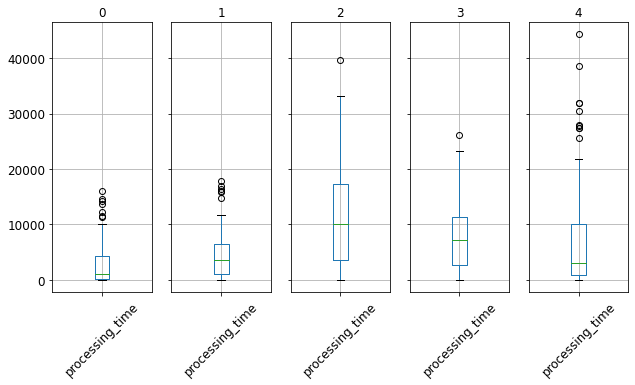

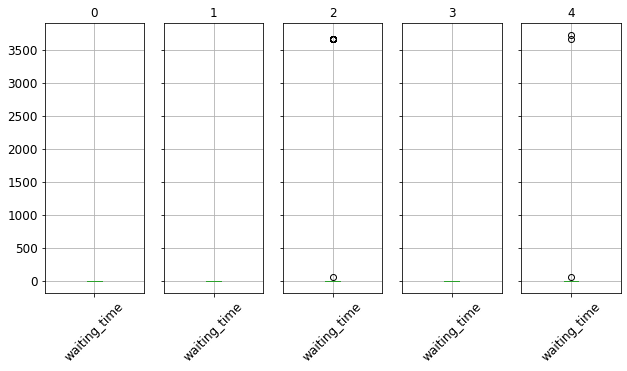

In [6]:
# One-hot encoding necessary because sk-learn dec. tree classifier does not handle categorical vars.
for c in cat_cols:
    activity_df[c] = activity_df[c].apply(str)
one_hot_data = pd.get_dummies(activity_df[cat_cols],drop_first=True)
enc_activity_df = pd.merge(activity_df.drop(columns=cat_cols), one_hot_data, left_index=True, right_index=True)

clf, rule_printer, path_visualizer, top_feature_getter, duration_stats_getter = explainer_sklearn_dt(enc_activity_df, "activity_cluster", exclude=["processing_time_quartile", "processing_time", "waiting_time", "accumulated_activity_time"], max_depth=3, min_samples_leaf=1, min_samples_split=0.1, criterion="entropy",level='activity')

rule_printer()

stats = duration_stats_getter(_figsize=(10, 5))
stats.describe()

##### Visualizing decision path of particular cases

In [7]:
cases = []
for cluster in np.unique(enc_activity_df.activity_cluster):
    case = enc_activity_df[enc_activity_df.activity_cluster == cluster].sample().iloc[0]
    cases.append(case)
    path_visualizer(case)

# To print the particular cases in a table, displaying the most important features of the decision tree + labels by different methods
pd.DataFrame(cases)[top_feature_getter(5)+['activity_cluster']]



Case class: 0.0
Reasons:
181.0 <= st_wip 
42254.0 <= end_daytime 
end_month_4 < 0.5


Case class: 1.0
Reasons:
181.0 <= st_wip 
end_wip < 196.0
end_daytime < 42254.0


Case class: 2.0
Reasons:
181.0 <= st_wip 
196.0 <= end_wip 
end_daytime < 42254.0


Case class: 3.0
Reasons:
181.0 <= st_wip 
42254.0 <= end_daytime 
0.5 <= end_month_4 


Case class: 4.0
Reasons:
st_wip < 181.0
119.0 <= end_wip 
20797.5 <= end_daytime 



,st_wip,end_daytime,end_month_4,end_wip,user_6799,activity_cluster
117,260.00,84241.00,0.00,260.00,0.00,0.00
2680,184.00,11597.00,0.00,184.00,0.00,1.00
964,318.00,2366.00,1.00,320.00,0.00,2.00
1043,314.00,83024.00,1.00,304.00,0.00,3.00
4003,146.00,64262.00,0.00,146.00,0.00,4.00


### Explainability: Processing Time quartiles

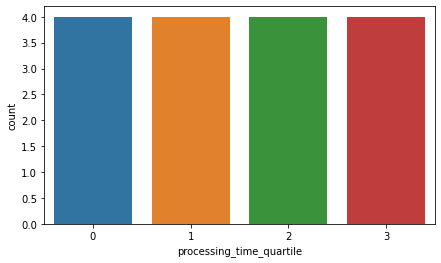


Grouping by processing_time_quartile

6 Decision Rules found:

if (end_month_4 > 0.5) and (rp_end_oc <= 0.031) then class = 1 | Prob: 100.0%, based on 4 samples
if (end_month_4 <= 0.5) and (rp_st_oc > 0.021) and (end_weekday_2 <= 0.5) then class = 2 | Prob: 100.0%, based on 4 samples
if (end_month_4 > 0.5) and (rp_end_oc > 0.031) then class = 0 | Prob: 100.0%, based on 3 samples
if (end_month_4 <= 0.5) and (rp_st_oc <= 0.021) then class = 3 | Prob: 100.0%, based on 3 samples
if (end_month_4 <= 0.5) and (rp_st_oc > 0.021) and (end_weekday_2 > 0.5) and (st_wip > 145.0) then class = 0 | Prob: 100.0%, based on 1 samples
if (end_month_4 <= 0.5) and (rp_st_oc > 0.021) and (end_weekday_2 > 0.5) and (st_wip <= 145.0) then class = 3 | Prob: 100.0%, based on 1 samples


processing_time                                     \
                                   count     mean     std      min      25%   
processing_time_quartile                                                      
0                                   4.00  2380.25 1833.02   838.00   946.00   
1                                   4.00 15294.50 2104.14 13691.00 13699.25   
2                                   4.00 30115.25 1388.08 28625.00 29268.50   
3                                   4.00 38915.25 4534.91 33205.00 37216.00   

                                                    waiting_time            \
                              50%      75%      max        count mean  std   
processing_time_quartile                                                     
0                         1994.50  3428.75  4694.00         4.00 0.00 0.00   
1                        14678.00 16273.25 18131.00         4.00 0.00 0.00   
2                        29993.00 30839.75 31850.00         4.00 0.00 0.00   
3                        39105.50 40804.75 44245.00         4.00 0.00 0.00   

                                                   
                          min  25%  50%  75%  max  
processing_time_quartile                           
0                        0.00 0.00 0.00 0.00 0.00  
1                        0.00 0.00 0.00 0.00 0.00  
2                        0.00 0.00 0.00 0.00 0.00  
3                        0.00 0.00 0.00 0.00 0.00

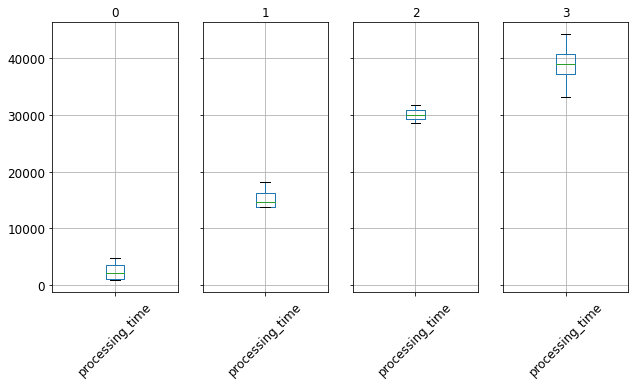

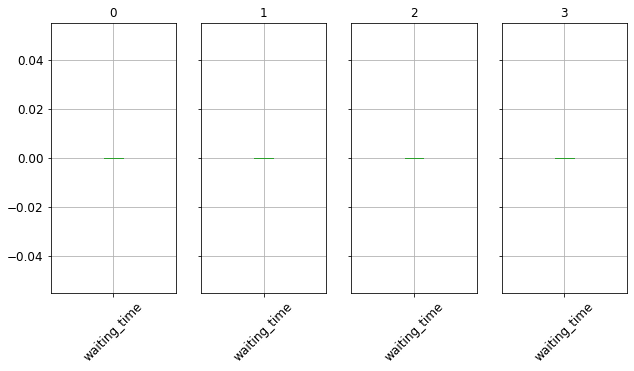

In [8]:
# One-hot encoding necessary because sk-learn dec. tree classifier does not handle categorical vars.
for c in cat_cols:
    activity_df[c] = activity_df[c].apply(str)
one_hot_data = pd.get_dummies(activity_df[cat_cols],drop_first=True)
enc_activity_df = pd.merge(activity_df.drop(columns=cat_cols), one_hot_data, left_index=True, right_index=True)

enc_activity_df = enc_activity_df.groupby('processing_time_quartile')
enc_activity_df = pd.DataFrame(enc_activity_df.apply(lambda x: x.sample(enc_activity_df.size().min()).reset_index(drop=True)))
enc_activity_df = enc_activity_df.reset_index(drop=True)

plt.subplots(figsize = (7, 4))
sns.countplot(x='processing_time_quartile', data = enc_activity_df)
plt.show()  

clf, rule_printer, path_visualizer, top_feature_getter, duration_stats_getter = explainer_sklearn_dt(enc_activity_df, "processing_time_quartile", exclude=["activity_cluster", "processing_time", "waiting_time", "accumulated_activity_time"], max_depth=4, min_samples_leaf=1, min_samples_split=0.1, criterion="entropy",level='activity')

rule_printer()

stats = duration_stats_getter(_figsize=(10, 5))
stats.describe()

In [9]:
cases = []
for processing_time_quartile in np.unique(enc_activity_df.processing_time_quartile):
    case = enc_activity_df[enc_activity_df.processing_time_quartile == processing_time_quartile].sample().iloc[0]
    cases.append(case)
    path_visualizer(case)

# To print the particular cases in a table, displaying the most important features of the decision tree + labels by different methods
pd.DataFrame(cases)[top_feature_getter(5)+['processing_time_quartile']]


Case class: 0.0
Reasons:
0.02 <= rp_st_oc 
end_month_4 < 0.5
end_weekday_2 < 0.5


Case class: 1.0
Reasons:
rp_end_oc < 0.03
0.5 <= end_month_4 


Case class: 2.0
Reasons:
rp_end_oc < 0.03
0.5 <= end_month_4 


Case class: 3.0
Reasons:
rp_end_oc < 0.03
0.5 <= end_month_4 



,end_month_4,rp_end_oc,end_weekday_2,rp_st_oc,st_wip,processing_time_quartile
1,0.00,0.00,1.00,0.03,184.00,0.00
5,1.00,0.02,0.00,0.19,352.00,1.00
10,0.00,0.00,0.00,0.05,258.00,2.00
12,0.00,0.00,0.00,0.02,96.00,3.00
